# Automated Mask Detection and Annotation Generation for Image Segmentation models

**Objective** : Given an image populated with objects of a single category, this Colab notebook endeavors to generate a COCO-formatted JSON annotation file corresponding to the image. The derived JSON file serves as a precursor to developing a dataset in the TF Records format, which in turn, is instrumental for training image segmentation models.

**Background**: The inception of this methodology is rooted in the scarcity of manually annotated data. By procuring images featuring multiple objects of a singular category, we can transition towards an automated annotation paradigm, substantially curtailing the expenses associated with manual annotation.

In this Colab notebook, we will employ the "Segment Anything" model from Facebook to identify masks for all objects within the given image. Subsequent to the mask detection, a post-processing step will be carried out to filter out unrelated masks, retaining only those pertinent to the target objects.

Following the mask refinement, we will leverage the Imantics library to transition the binary masks into a COCO JSON annotation format. This conversion facilitates the representation of multiple objects within a structured annotation file, paving the way for further analysis and utilization in image segmentation tasks.





The resulted COCO JSON file from this colab can be merged with other COCO JSON files using this [notebook](https://github.com/tensorflow/models/blob/master/official/projects/waste_identification_ml/pre_processing/merge_coco_files_faster.ipynb) from our project. The final merged COCO JSON file along with the corresponding images can then be converted to TFRecod format using this [notebook](https://github.com/tensorflow/models/blob/master/official/projects/waste_identification_ml/pre_processing/coco_to_tfrecord.ipynb).

## Importing and Installing Required Libraries


In [ ]:
# This command installs the 'Segment Anything' library directly from its GitHub
# repository.
# 'Segment Anything' is a project by Facebook Research, which provides tools for
# object segmentation.
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q imantics

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models 2>/dev/null

In [ ]:
import torch
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, SamPredictor
from typing import Any
import sys

sys.path.append('models/official/projects/waste_identification_ml/data_generation/')
import utils

%matplotlib inline

In [ ]:
# This line of code checks and prints whether CUDA is available on this machine.
# CUDA is a parallel computing platform and application programming interface
# model created by NVIDIA. It allows developers to use CUDA-enabled graphics
# processing units (GPUs) for general purpose processing.
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


## Load Segment Anything model

In [ ]:
# This command quietly downloads the pre-trained model checkpoint file
# 'sam_vit_h_4b8939.pth' for the ViT-H SAM model from Segment Anything project.
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

In [ ]:
# Specify the path to the pre-trained model checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"

# Define the model type to be used
model_type = "vit_h"

# Specify the device to be used for model deployment; 'cuda' implies that a GPU
# is being used
device = "cuda"

# Load the pre-trained model using the specified checkpoint and model type from
# the SAM model registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Transfer the model to the specified device
sam.to(device=device)

# Instantiate an automatic mask generator using the loaded SAM model
mask_generator = SamAutomaticMaskGenerator(sam)

## Inferencing

In [ ]:
# download the sample image from the circularnet project
url = (
    "https://raw.githubusercontent.com/tensorflow/models/master/official/"
    "projects/waste_identification_ml/pre_processing/config/sample_images/"
    "image_4.png"
)

!curl -O {url} > /dev/null 2>&1

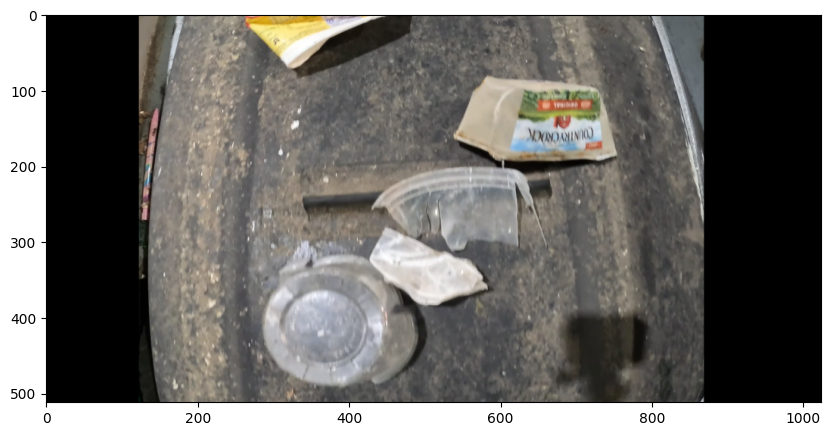

In [ ]:
# Reading an image file.
original_image = cv2.imread('image_4.png')
image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024,512), interpolation = cv2.INTER_AREA)
utils.plot_image(image)

To generate masks, just run `generate` on an image.

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

*   `segmentation` : the mask
*   `area` : the area of the mask in pixels
*   `bbox` : the boundary box of the mask in XYWH format
*   `predicted_iou` : the model's own prediction for the quality of the mask
*   `point_coords` : the sampled input point that generated this mask
*   `stability_score` : an additional measure of mask quality
*   `crop_box` : the crop of the image used to generate this mask in XYWH format










Total number of masks found: 48


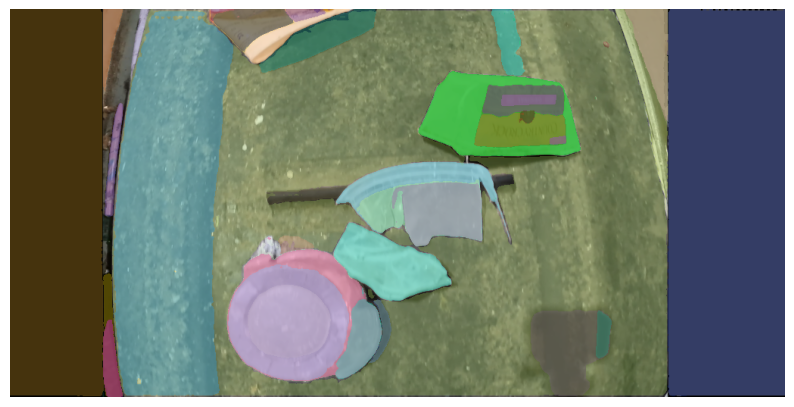

In [ ]:
result = mask_generator.generate(image)
print("Total number of masks found:", len(result))
utils.display_image_with_annotations(image, result)

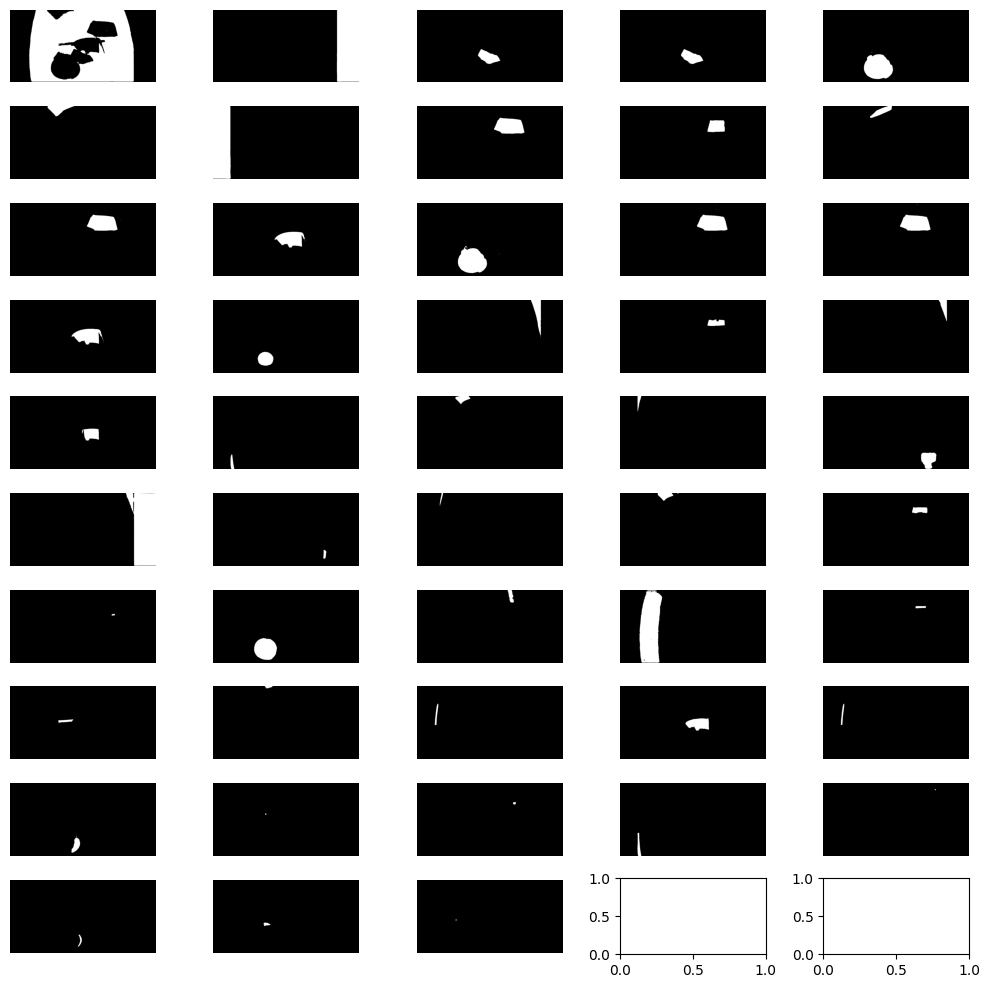

In [ ]:
# Display all the detected masks.
utils.plot_grid(result, n_cols=5)

In the output you can see that the model detected many masks which do not represent the object of interest and represent a part of the background. Many overlapping masks were also detected which belong to the same objects.

## Convert bbox format

In [ ]:
# converting bbox format from XYWH to xmin, ymin, xmax, ymax
for element in result:
  element['bbox'] = utils.convert_bbox_format(element['bbox'])

## Mask filtering.

The code snippet is analyzing a list of masks (**filtered_masks**) to find pairs of masks that are nested or similar based on a nesting score. If a pair of masks has a nesting score greater than **0.95**, it identifies the mask with the bigger area. An object may have multiple similar masks which are either completely nested into each other or not. Our goal is to keep only the mask of an object which has the maximum area. Each object should only have one mask.

Total number of filtered masks found: 17


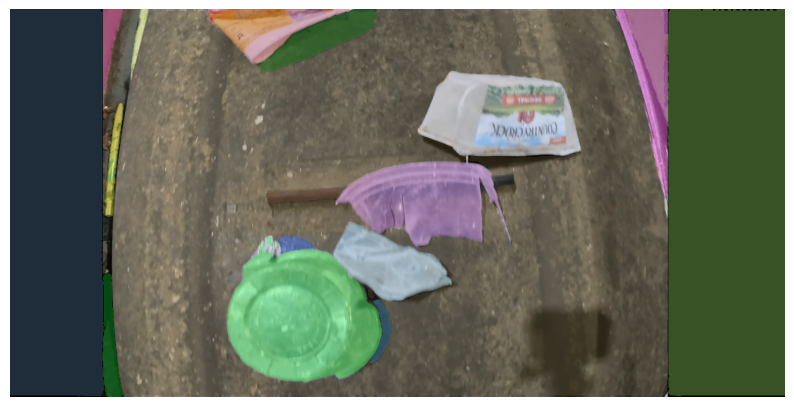

In [ ]:
if result:
  filtered_unnested_results = utils.filter_nested_similar_masks(result)
  print("Total number of filtered masks found:", len(filtered_unnested_results))

  utils.display_image_with_annotations(image, filtered_unnested_results)

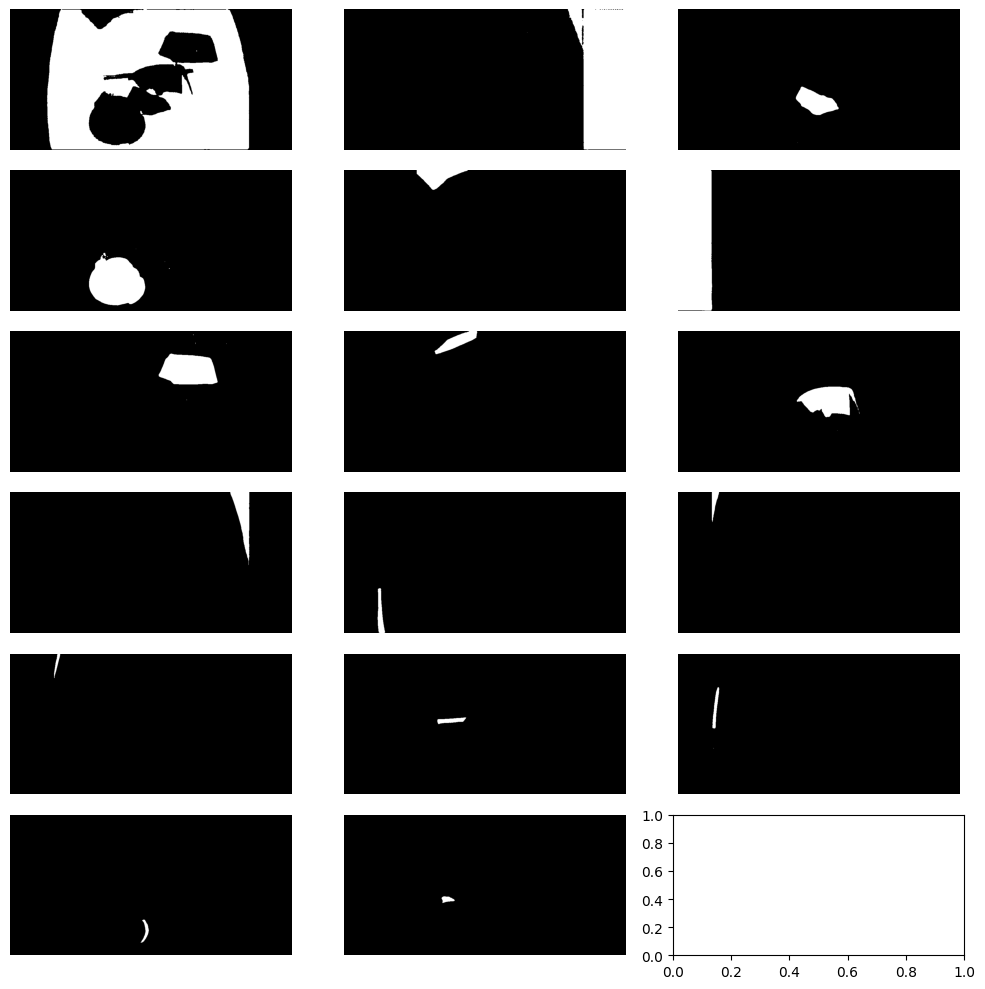

In [ ]:
# Display all the masks after the previous filtering step.
utils.plot_grid(filtered_unnested_results, n_cols=3)

we can see the model detected too many masks which does not represents objects. We will now filter out the masks according to the aspect ration of the bounding boxes and the area of the masks. Masks which are too long, too big or too small will be filtered out in the process below.

In [ ]:
UPPER_MULTIPLIER = 6
LOWER_MULTIPLIER = 2
AREA_FILTER_THRESH = 0.15

Total number of filtered masks found: 5


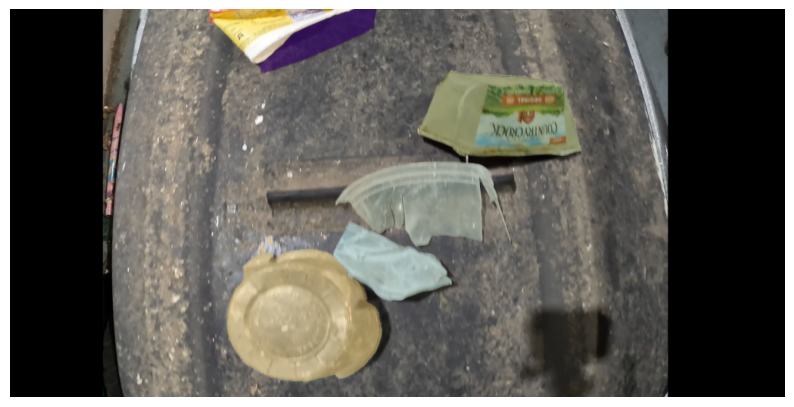

In [ ]:
if filtered_unnested_results:
  filtered_masks = utils.filter_masks(image, filtered_unnested_results, UPPER_MULTIPLIER, LOWER_MULTIPLIER, AREA_FILTER_THRESH)
  print("Total number of filtered masks found:", len(filtered_masks))

  utils.display_image_with_annotations(image, filtered_masks)

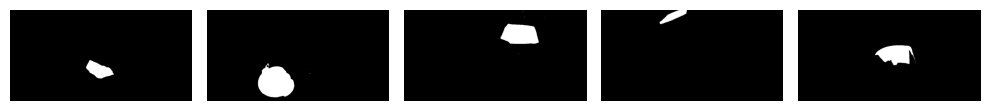

In [ ]:
# Display all the masks after the previous filtering step.
utils.plot_grid(filtered_masks, n_cols=5)

# Conversion to COCO JSON format

In [ ]:
# Converting the masks to the required input format.
if filtered_masks:
  final_masks = []
  for i in filtered_masks:
    mask_uint8 = i['segmentation'].astype(np.uint8) * 255
    resized_mask_uint8 = cv2.resize(
        mask_uint8,
        (original_image.shape[1], original_image.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )
    final_masks.append(resized_mask_uint8)

In [ ]:
# Assign the category name for all objects in the required COCO JSON file.
category_name = 'Plastics_PP'

# Desired name of an image in COCO JSON file.
image_name = 'xyz.png'

coco_json_file = utils.generate_coco_json(
    final_masks,
    original_image,
    category_name,
    image_name
)

In [ ]:
# Display the information abvout an image.
coco_json_file['images']

[{'id': 0,
  'width': 1920,
  'height': 1080,
  'file_name': 'xyz.png',
  'path': '',
  'license': None,
  'fickr_url': None,
  'coco_url': None,
  'date_captured': None,
  'metadata': {}}]

In [ ]:
# Display the information about the categories of the objects present in that
# image.
coco_json_file['categories']

[{'id': 1,
  'name': 'Plastics_PP',
  'supercategory': None,
  'metadata': {},
  'color': '#98f270'}]

In [ ]:
# Number of objects which were detected in an image.
len(coco_json_file['annotations'])

5